In [81]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pulp import *
import geopandas as gpd
from shapely.geometry import Point
from scipy.spatial import distance
import folium
from folium.plugins import MarkerCluster

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

os.chdir('/Users/chengchen/Desktop/Insight/project/')

In [3]:
def df_to_gdf(df):
    """takes a dataframe with columns named 'longitude' and 'latitude' 
    to transform to a geodataframe with point features"""
    
    df['coordinates'] = df[['longitude', 'latitude']].values.tolist()
    df['coordinates'] = df['coordinates'].apply(Point)
    df = gpd.GeoDataFrame(df, geometry = 'coordinates')
    return df


* import datasets


In [4]:
df_demand = pd.read_excel('data/cleaned/optimization_CT_AM_trips_cluster.xlsx')
df_parking= pd.read_excel('data/cleaned/optimization_parking_location_cluster.xlsx')
df_parking['local_id'] = np.arange(len(df_parking))
df_demand['local_id']=np.arange(len(df_demand))

* generate sets, variables, and parameters

In [5]:
def gen_sets(cluster_id, df_demand, df_parking):
    """Generate sets to use in the optimization problem"""
    # set of charging demand locations (destinations)
    df_demand_cls = df_demand.loc[df_demand['parking_cluster'] == cluster_id]
    demand_lc = df_demand_cls.index.tolist()
    # set of candidates for charging station locations (currently existing parking lots)
    df_parking_cls = df_parking.loc[df_parking['cluster'] == cluster_id]
    chg_lc = df_parking_cls.index.tolist()
    return demand_lc, chg_lc
def gen_parameters(cluster_id, df_demand, df_parking):
    """Generate parameters to use in the optimization problem, 
    including capacity of charging station, cost to install charging stations, 
    and travel costs to and from the charging stations (present value)"""
    # fixed cost to install a charging station with 5 level II chargers
    df_parking_cls = df_parking.loc[df_parking['cluster'] == cluster_id].copy()
    df_parking_cls['fixed_cost'] = 11000
    fixed_cost = df_parking_cls['fixed_cost'].to_dict()
    
    # capacity: 5 chargers, with each charger charging 4 cars at most per day
    df_parking_cls['chg_capacity'] = 20
    capacity = df_parking_cls['chg_capacity'].to_dict()
    
    # distance matrix of charging station location candidates and charging demand location
    
    coords_pk = [(x,y) for x,y in zip(df_parking_cls['longitude'],df_parking_cls['latitude'])]
    df_demand_cls = df_demand.loc[df_demand['parking_cluster']==cluster_id]
    coords_trip = [(x,y) for x,y in zip(df_demand_cls['long'],df_demand_cls['lat'])]

    distance_matrix = distance.cdist(coords_pk, coords_trip, 'euclidean')
    transfer_ratio = 85
    distance_matrix2 = transfer_ratio*distance_matrix
    df_distance = pd.DataFrame(distance_matrix2, index = df_parking_cls.index.tolist() ,columns = df_demand_cls.index.tolist())
    df_travel_cost = df_distance * 1457
    dic_cost_matrix = df_travel_cost.to_dict('index')
    
    
    #df_distance = pd.read_excel('data/cleaned/distance_mtx_'+ward+'.xlsx')
    #df_travel_cost = df_distance * 1457
    #dic_cost_matrix = df_travel_cost.to_dict('index')
    return fixed_cost, capacity, dic_cost_matrix
fixed_cost, capacity, dic_cost_matrix = gen_parameters(1, df_demand, df_parking)    
def gen_demand(df, demand_ratio, column = 'CT_AM_trips'):
    """generate the (unsatisfied) demand for charging (during day time) for each census tract, 
    which equals to total demand for charging minus charging capacity of currently existing charging stations"""
    df1 = df.copy()
    df1['demand_chg'] = df1[column]*demand_ratio
    df1['extra_demand_chg'] = df1['demand_chg'] - df1['charging s']*20
    # replace the negative charging demand to 0
    num = df1._get_numeric_data()
    num[num < 0] = 0 
    df1 = df1.round({'extra_demand_chg':0})
    return df1
list_demand_ratio = np.linspace(0.00118, 0.038, num=30).tolist()
list_id = np.arange(30)


### various kinds of optimization models
* Original Model (min (cost+travel cost) s.t. demand constraint + capacity constraint)

In [18]:
def optimize_cls1(cluster_id, df_demand, df_parking, demand_ratio):
    demand_lc, chg_lc = gen_sets(cluster_id, df_demand, df_parking)
    fixed_cost, capacity, dic_cost_matrix = gen_parameters(cluster_id, df_demand, df_parking)
    df_demand_cls = df_demand.loc[df_demand['parking_cluster'] == cluster_id]
    df_demand = gen_demand(df_demand_cls, demand_ratio)
    demand = df_demand['demand_chg'].to_dict()
    # set up the optimization problem
    prob = LpProblem('FacilityLocation', LpMinimize)
    serv_vars = LpVariable.dicts("Service",
                                 [(i,j) for i in demand_lc
                                        for j in chg_lc],
                                  0)
    use_vars = LpVariable.dicts("UseLocation", chg_lc, 0, 1, LpBinary)
    prob += lpSum(fixed_cost[j]*use_vars[j] for j in chg_lc) \
    + lpSum(dic_cost_matrix[j][i]*serv_vars[(i,j)] for j in chg_lc for i in demand_lc) 
    for i in demand_lc:
        prob += lpSum(serv_vars[(i,j)] for j in chg_lc) == demand[i] # constraint 1
    for j in chg_lc:
        prob += lpSum(serv_vars[(i,j)] for i in demand_lc) <= capacity[j]*use_vars[j]
    for i in demand_lc:
        for j in chg_lc:
            prob += serv_vars[(i,j)] <= demand[i]*use_vars[j]
    print(cluster_id)
    prob.solve()
    print("Status: ", LpStatus[prob.status])
    TOL = .00001
    opt_location = []
    for i in chg_lc:
        if use_vars[i].varValue > TOL:
            opt_location.append(i)
            print("Eslablish charging station at site", i)
    df_status = pd.DataFrame({"cluster": [cluster_id], "status": [LpStatus[prob.status]], "N_chg": [len(opt_location)]})
    return opt_location, df_status
        
opt_location, df_status = optimize_cls1(2, df_demand, df_parking, list_demand_ratio[10])

2
Status:  Infeasible
Eslablish charging station at site 90
Eslablish charging station at site 95
Eslablish charging station at site 96
Eslablish charging station at site 97
Eslablish charging station at site 98
Eslablish charging station at site 99
Eslablish charging station at site 100
Eslablish charging station at site 101
Eslablish charging station at site 102
Eslablish charging station at site 121


* Model 2 (allow unsatisfied demand), i.e., min(installation cost + travel cost + penalty for unsatisfied demand) s.t. capacity constraint

In [19]:
def optimize_cls2(cluster_id, df_demand, df_parking, demand_ratio, penalty = 1650):
    demand_lc, chg_lc = gen_sets(cluster_id, df_demand, df_parking)
    fixed_cost, capacity, dic_cost_matrix = gen_parameters(cluster_id, df_demand, df_parking)
    df_demand_cls = df_demand.loc[df_demand['parking_cluster'] == cluster_id]
    df_demand = gen_demand(df_demand_cls, demand_ratio)
    demand = df_demand['demand_chg'].to_dict()
    # set up the optimization problem
    prob = LpProblem('FacilityLocation', LpMinimize)
    serv_vars = LpVariable.dicts("Service",
                                 [(i,j) for i in demand_lc
                                        for j in chg_lc],
                                  0)
    use_vars = LpVariable.dicts("UseLocation", chg_lc, 0, 1, LpBinary)
    prob += lpSum(fixed_cost[j]*use_vars[j] for j in chg_lc) \
    + lpSum(dic_cost_matrix[j][i]*serv_vars[(i,j)] for j in chg_lc for i in demand_lc) \
    + lpSum(demand[i]-lpSum(serv_vars[(i,j)] for j in chg_lc) for i in demand_lc)*penalty
#    for i in demand_lc:
#        prob += lpSum(serv_vars[(i,j)] for j in chg_lc) == demand[i] # constraint 1
    for j in chg_lc:
        prob += lpSum(serv_vars[(i,j)] for i in demand_lc) <= capacity[j]*use_vars[j]
    for i in demand_lc:
        for j in chg_lc:
            prob += serv_vars[(i,j)] <= demand[i]*use_vars[j]
    print(cluster_id)
    prob.solve()
    print("Status: ", LpStatus[prob.status])
    TOL = .00001
    opt_location = []
    for i in chg_lc:
        if use_vars[i].varValue > TOL:
            opt_location.append(i)
            print("Eslablish charging station at site", i)
    df_status = pd.DataFrame({"cluster": [cluster_id], "status": [LpStatus[prob.status]], "N_chg": [len(opt_location)]})
    return opt_location, df_status
        
opt_location, df_status = optimize_cls2(2, df_demand, df_parking, list_demand_ratio[10])

2
Status:  Optimal
Eslablish charging station at site 90
Eslablish charging station at site 95
Eslablish charging station at site 96
Eslablish charging station at site 97
Eslablish charging station at site 98
Eslablish charging station at site 100
Eslablish charging station at site 121


### Model 3: min(travel cost + penalty for unsatisfied demand) s.t. ( capacity constraint + budget constraint)

In [175]:
def gen_cluster_demand_ratio(df_demand, cluster_id):
    """generate a demand ratio for a given cluster: how much of total traffic is flowing into this cluster?"""
    df_demand['cluster_demand_ratio'] = df_demand['cluster_trip']/total_trip
    df_cluster_demand = df_demand[['parking_cluster','cluster_demand_ratio']].drop_duplicates(subset ="parking_cluster")
    cluster_demand_ratio = df_cluster_demand[df_cluster_demand['parking_cluster']==cluster_id]['cluster_demand_ratio']
    return cluster_demand_ratio

In [176]:
def optimize_cls3(cluster_id, df_demand, df_parking, demand_ratio, n_total_budget, penalty = 1650):
    demand_lc, chg_lc = gen_sets(cluster_id, df_demand, df_parking)
    fixed_cost, capacity, dic_cost_matrix = gen_parameters(cluster_id, df_demand, df_parking)
    df_demand_cls = df_demand.loc[df_demand['parking_cluster'] == cluster_id]
    df_demand = gen_demand(df_demand_cls, demand_ratio)
    cluster_demand_ratio = gen_cluster_demand_ratio(df_demand, cluster_id)
    budget = 11000*round(n_total_budget*cluster_demand_ratio)

    demand = df_demand['demand_chg'].to_dict()
    # set up the optimization problem
    prob = LpProblem('FacilityLocation', LpMinimize)
    serv_vars = LpVariable.dicts("Service",
                                 [(i,j) for i in demand_lc
                                        for j in chg_lc],
                                  0)
    use_vars = LpVariable.dicts("UseLocation", chg_lc, 0, 1, LpBinary)
    prob += lpSum(dic_cost_matrix[j][i]*serv_vars[(i,j)] for j in chg_lc for i in demand_lc) \
    + lpSum(demand[i]-lpSum(serv_vars[(i,j)] for j in chg_lc) for i in demand_lc)*penalty
#    for i in demand_lc:
#        prob += lpSum(serv_vars[(i,j)] for j in chg_lc) == demand[i] # constraint 1
    for j in chg_lc:
        prob += lpSum(serv_vars[(i,j)] for i in demand_lc) <= capacity[j]*use_vars[j]
    for i in demand_lc:
        for j in chg_lc:
            prob += serv_vars[(i,j)] <= demand[i]*use_vars[j]
    prob += lpSum(fixed_cost[j]*use_vars[j] for j in chg_lc) <= budget
    print(cluster_id)
    prob.solve()
    print("Status: ", LpStatus[prob.status])
    TOL = .00001
    opt_location = []
    for i in chg_lc:
        if use_vars[i].varValue > TOL:
            opt_location.append(i)
            print("Establish charging station at site", i)
    df_status = pd.DataFrame({"cluster": [cluster_id], "status": [LpStatus[prob.status]], "N_chg": [len(opt_location)]})
    return opt_location, df_status
        
opt_location, df_status = optimize_cls3(2, df_demand, df_parking, list_demand_ratio[10], n_total_budget = 100, penalty=1650)

2
Status:  Optimal
Establish charging station at site 90
Establish charging station at site 96
Establish charging station at site 97
Establish charging station at site 98
Establish charging station at site 100
Establish charging station at site 121


In [35]:
df_demand['cluster_trip']=df_demand['CT_AM_trips'].groupby(df_demand['parking_cluster']).transform('sum')
total_trip = df_demand['CT_AM_trips'].sum()
df_demand.head()

,CTNAME,charging s,POP06,L_AREA,ward,long,lat,CT_AM_trips,parking_cluster,local_id,cluster_trip
0,1.0,2,571,6.10,Ward 28,-79.335397,43.647242,1285.060838,39,0,4687.142731
1,2.0,0,627,3.17,Ward 28,-79.381859,43.623125,2581.374046,7,1,12505.154092
2,3.0,0,0,0.00,Ward 5,-79.451040,43.635331,1004.688287,34,2,10651.201883
3,4.0,0,6861,0.34,Ward 14,-79.439767,43.637460,714.248927,21,3,14241.337103
4,5.0,0,5089,0.38,Ward 14,-79.430487,43.639907,655.718071,21,4,14241.337103


39    0.036777
Name: cluster_demand_ratio, dtype: float64

In [39]:
df_demand['cluster_demand_ratio'] = df_demand['cluster_trip']/total_trip
df_cluster_demand = df_demand[['parking_cluster','cluster_demand_ratio']].drop_duplicates(subset ="parking_cluster")
df_cluster_demand.head()

,parking_cluster,cluster_demand_ratio
0,39,0.008057
1,7,0.021497
2,34,0.018310
3,21,0.024481
14,37,0.018993


In [105]:
cluster_id = 1
n_total_budget = 100
cluster_demand_ratio = df_cluster_demand[df_cluster_demand['parking_cluster']==cluster_id]['cluster_demand_ratio']
n_budget = round(n_total_budget*cluster_demand_ratio)
# REDFLAG: the way you set ratios for each districts should be: proportional to unsatisfied demand, not total demand!
# problem fixed 
n_budget

39    4.0
Name: cluster_demand_ratio, dtype: float64

In [63]:
df_demand.head()

,CTNAME,charging s,POP06,L_AREA,ward,long,lat,CT_AM_trips,parking_cluster,local_id,cluster_trip,cluster_demand_ratio
0,1.0,2,571,6.10,Ward 28,-79.335397,43.647242,1285.060838,39,0,4687.142731,0.008057
1,2.0,0,627,3.17,Ward 28,-79.381859,43.623125,2581.374046,7,1,12505.154092,0.021497
2,3.0,0,0,0.00,Ward 5,-79.451040,43.635331,1004.688287,34,2,10651.201883,0.018310
3,4.0,0,6861,0.34,Ward 14,-79.439767,43.637460,714.248927,21,3,14241.337103,0.024481
4,5.0,0,5089,0.38,Ward 14,-79.430487,43.639907,655.718071,21,4,14241.337103,0.024481


In [177]:
cluster_list = [i for i in range(40)]
df_chg_stn = pd.read_excel('data/raw/TRT_charging.xlsx')
gdf_chg_stn = df_to_gdf(df_chg_stn)
def main_map_generater(demand_ratio, df_demand, df_parking, cluster_list, n_total_budget, penalty):
    opt_chg_location = []
    df_output_status = pd.DataFrame(columns = ['cluster', 'status', 'N_chg'])
    for cluster_id in cluster_list:
        opt_location, df_status = optimize_cls3(cluster_id, df_demand, df_parking, demand_ratio, n_total_budget, penalty)
        opt_chg_location += opt_location
        df_output_status =df_output_status.append(df_status)
    df_output_status.to_excel('data/processed/model2/chg_stn_status_cluster_demand_ratio'+str(demand_ratio)[2:]+'.xlsx')
    df_opt_chg_lc = df_parking.ix[opt_chg_location]
    df_opt_chg_lc.to_excel('data/processed/model2/chg_stn_location_cluster_demand_ratio'+str(demand_ratio)[2:]+'.xlsx')
    gdf_optimal_parking = df_to_gdf(df_opt_chg_lc)
    gdf_optimal_parking.plot()
    plt.savefig('graphs/model2/location_cluster_demand_ratio_'+str(demand_ratio)[2:]+'.jpg')
    # draw map using folium
    # add base layer --- map of Toronto
    lat, lng = 43.653908, -79.384293  # Toronto City Hall
    map_TRT = folium.Map(location=[lat, lng], zoom_start = 14) 
    # add layer --- existing charging stations
    chg_layer = folium.FeatureGroup(name = 'Existing Charging Stations')
    marker_cluster = MarkerCluster()
    for idx, row in gdf_chg_stn.iterrows():
        folium.Marker([float(row['coordinates'].y), 
                       float(row['coordinates'].x)], 
                     popup = row['Name']).add_to(marker_cluster)
    chg_layer.add_child(marker_cluster)
    map_TRT.add_child(chg_layer)
    # add layer --- suggested extra charging stations
    #gdf_optimal_parking.crs = {'init' :'epsg:4326'}
    #optimal_chg_stn_json = gdf_optimal_parking.to_json()
    opt_chg_layer = folium.FeatureGroup(name = 'Suggested Charging Station Locations')
    marker_cluster = MarkerCluster()
    for idx, row in gdf_optimal_parking.iterrows():
        folium.Marker([float(row['coordinates'].y), 
                       float(row['coordinates'].x)], 
                    icon = folium.Icon(color = 'green', icon = 'circle'),
                     popup = row['Name']).add_to(marker_cluster)
    opt_chg_layer.add_child(marker_cluster)
    map_TRT.add_child(opt_chg_layer)
    map_TRT.add_child(folium.LayerControl())
    map_TRT.save('graphs/model2/folium/TRT_map_demand_ratio_'+str(demand_ratio)[2:]+'.html')
    return df_output_status, gdf_optimal_parking
#df_output_status, gdf_optimal_parking = main_map_generater(0.002,df_demand, df_parking, cluster_list, n_total_budget = 100, penalty = 1650)    

* load in previous optimization results and compare !!!!!

In [71]:
list_demand_ratio = np.linspace(0.00118, 0.038, num=30).tolist()
list_id = np.arange(30)
df_list = []
for i in list_id:
    demand_ratio = list_demand_ratio[i]
    df = pd.read_excel('data/processed/chg_stn_location_cluster_demand_ratio'+str(demand_ratio)[2:]+'.xlsx')
    df_list.append(df)

In [123]:
df_opt_result1 = df_list[10]

In [124]:
n_total_budget = df_opt_result1.shape[0]

0
Status:  Optimal
Establish charging station at site 160
Establish charging station at site 178
Establish charging station at site 221
Establish charging station at site 278
Establish charging station at site 284
Establish charging station at site 285
1
Status:  Optimal
Establish charging station at site 476
Establish charging station at site 480
Establish charging station at site 481
Establish charging station at site 482
Establish charging station at site 487
Establish charging station at site 491
Establish charging station at site 492
Establish charging station at site 494
Establish charging station at site 495
Establish charging station at site 586
Establish charging station at site 590
Establish charging station at site 592
Establish charging station at site 596
2
Status:  Optimal
Establish charging station at site 90
Establish charging station at site 95
Establish charging station at site 96
Establish charging station at site 97
Establish charging station at site 98
Establish ch

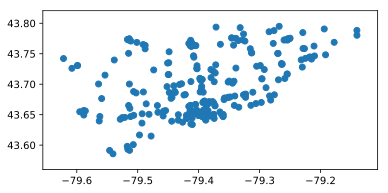

In [192]:
df_output_status, gdf_optimal_parking = main_map_generater(list_demand_ratio[10],df_demand, df_parking, cluster_list, n_total_budget = n_total_budget, penalty = 900)    

In [193]:
chg_id_model1 = df_list[10].local_id.tolist()
chg_id_model2 = gdf_optimal_parking.local_id.tolist()

In [194]:
len(chg_id_model1)

353

In [195]:
len(chg_id_model2)

252

In [196]:
c = sum(el in chg_id_model1 for el in chg_id_model2)
c/len(chg_id_model2)

0.8333333333333334

In [197]:
c

210

In [198]:
n_total_budget

353